# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import torch
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux_NoVis/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.09000000171363354
Score (max over agents) from episode 2: 0.09000000171363354
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.09000000171363354
Score (max over agents) from episode 5: 0.0


When finished, you can close the environment.

In [10]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

***Goal:*** Based on the rubric, the agents must get an average award of +0.5 in over 100 consecutive episodes, after taking the maximum over both agents.

### 5. Learning Algorithm Training Description
***Overview:***

The agent uses a standard ***Multi-Agent Deep Deterministic Policy Gradient (MADDPG)*** model with two DDPG agent, each agent containing Experience Replay and fixed Q-Targets. DDPG is a deterministic and off-policy variation of an Actor-Critic method, and closely connected with to DQN. The Actors of the DDPG agents in MADDPG follow the same algo as Actor of standalone DDPG agent: taking a deterministic action that it thinks can maximize state-action value. However, what makes MADDPG quite interesting is that each and every DPPG Critic has access to ***all*** DPPG Actors' action decisions in MADDPG, known as the *centralized action-value function*, and not just the Actor within its own agent. Agents will still most likely finalize on diverse policies from each other due their differing *observations*, such as their respective locations in the env. Nevertheless, this level of omnipotency allows agent Critics to absorb policies from other agents during training, enabling agents to create *policy ensembles* leading to more robust performance in originally non-stationary environment, if the agents are blinded from each others' action. This is especially fruitful in coorperative scenarios, where the agents need to communicate and work together in order to achieve even higher scores individually. After training and during actual deployment, the agents will of course lose this omnipotency as their Actors will be operating and learning individually in the env, and can only access their own policies.

Source: https://papers.nips.cc/paper/7217-multi-agent-actor-critic-for-mixed-cooperative-competitive-environments.pdf

***Model Description:***

My MADDPG contains 2 DDPG agents, the number of agents provided by the Tennis end. For each DDPG, both Actor and Critic (as well as their respective local and target networks) have two hidden layers, with first one (fc1) having 512 units and second one (fc2) having 256 units. I am additionally using Leaky ReLu rather than ReLu to prevent neurons from getting "stuck" due to 0 values. Finally, I have removed the OUNoise as it interferes too much MADDPG, which is already sensitive enough.

* `BUFFER_SIZE` = 100000 (1e6)
* `BATCH_SIZE` = 512
* `GAMMA` = 0.99
* `TAU` = 0.01
* `LR_ACTOR` = 0.0002  (learning rate of actor) 
* `LR_CRITIC` = 0.0002 (learning rate of critic)
* `WEIGHT_DECAY` = 0   (L2) 
* `UPDATE_EVERY` = 2
* `UPDATE_AMOUNT` = 1

In [6]:
from maddpg_agent import MADDPG
agents = MADDPG(num_agents=num_agents, state_size=state_size,
                                       action_size=action_size, random_seed=2)

In [7]:
def train(n_episodes=100, max_t=1000):
    """Multi-Agent Deep Deterministic Policy Gradiant.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    scores_window = deque(maxlen=100)  # last 100 scores
    scores_output = []

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agents.reset()
        scores = np.zeros(num_agents) # initialize all the agents' scores to 0

        for t in range(max_t):
            actions = agents.act(states)  # select an action
            env_info = env.step(actions)[brain_name]  # send the action to env
            next_states = env_info.vector_observations  # get the next state
            rewards = env_info.rewards  # get the reward
            done = env_info.local_done  # see if episode has finished
            agents.step(states, actions, rewards, next_states, done)
            states = next_states
            scores += rewards
            if np.any(done):
                break

        max_score = np.max(scores)
        scores_window.append(max_score)    # save maximum score among the agents
        scores_output.append(max_score)    # save maximum score among the agents
        avg_score = np.mean(scores_window) # retrieve the agents' avg score

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if avg_score >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            for agent in agents.agents:
                actor = agent.actor_local.state_dict()
                critic = agent.critic_local.state_dict()
                id = agent.agent_id
                torch.save(actor, f'checkpoint_a{id}_actor.pth')
                torch.save(critic, f'checkpoint_a{id}_critic.pth')
            break

    return scores_output

### 6. Execution

In [8]:
scores = train(n_episodes=2500)

Episode 100	Average Score: 0.00
Episode 200	Average Score: 0.00
Episode 300	Average Score: 0.00
Episode 400	Average Score: 0.01
Episode 500	Average Score: 0.05
Episode 600	Average Score: 0.08
Episode 700	Average Score: 0.08
Episode 800	Average Score: 0.11
Episode 900	Average Score: 0.13
Episode 1000	Average Score: 0.15
Episode 1100	Average Score: 0.15
Episode 1200	Average Score: 0.15
Episode 1300	Average Score: 0.19
Episode 1400	Average Score: 0.19
Episode 1500	Average Score: 0.16
Episode 1600	Average Score: 0.26
Episode 1700	Average Score: 0.35
Episode 1800	Average Score: 0.31
Episode 1900	Average Score: 0.29
Episode 2000	Average Score: 0.43
Episode 2100	Average Score: 0.38
Episode 2200	Average Score: 0.46
Episode 2212	Average Score: 0.51
Environment solved in 2212 episodes!	Average Score: 0.51


### 7. Plot of Rewards
***Number of Eps:*** 2212

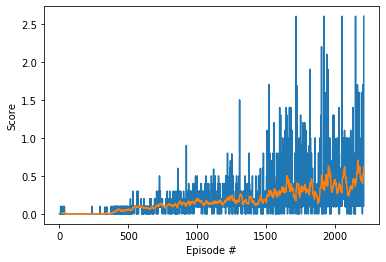

In [9]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(len(scores)), pd.DataFrame(scores).rolling(20).mean())
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 8. Ideas for Future Work
***Performance Improvement:***

1) ***Prioritized Experienced Replay***: As explained in my Navigation project, this allows my model to learn from more "important" experiences more frequently. Importance in terms of the absolute TD Error. Improvement on more "important" experiences allows for faster gradient descent off the cost function, or faster increase of the score. Experience prioritization is something I am still currently missing.

2) ***Update Amount***: I think the model can converge in less episode if it learns multiple times each step. However, the trade-off is that each n-step learning interval will be slower per increment of update amount.

3) ***Learning Rate***: I have intentionally set the learning rate low in order for the model to slowly yet steadily train. I can further try to tweak to rates higher, but from my experience, it leads to more inconsistent results.

4) ***MAD4PG***: As explained Continuous Control project, Distributed Distributional Deep Deterministic Policy Gradient (D4PG) apparently improves upon DDPG in terms of coping with more complicated continuous environments, including this one. I assume that that also applies to MAD4PG comparison with MADDPG.

5) ***PPO/TRPO***: Using the following policy-only models can potentially provide more robust performance due to their sampling efficiency and use of penalities. Could possibly use PPO or TRPO that as an Actor rather than DQN. *Source*: https://medium.com/@sanketgujar95/trust-region-policy-optimization-trpo-and-proximal-policy-optimization-ppo-e6e7075f39ed

6) ***GPU Cluster***: I am currently running it on my own CPU laptop, which is painfully slow. I should try to run it on a GPU Cluster (i.e. cloud) in order to do training in-parallel. There is where I can experiment with asynchronous models, such as A3C. 

7) ***Soccer***: As future work, I can test the above Performance Improvement ideas with the Soccer project, which has more agents to manage. 